# ANALYSE DES VENTES D'UNE LIBRAIRIE SOUS PYTHON

## SOMMAIRE

1. [Elements de contexte](#introduction)
2. [Tendance globales et indicateurs de conjoncture](#paragraph1)
    1. [Etapes préliminaires et chiffre clés](#Subparagraph1)
    2. [Analyse approfondie des tendances](#Subparagraph2) 
3. [Profil de consommation des clients](#paragraph2)
    1. [Les clients particuliers](#Subparagraph3)
    1. [Les clients professionnels](#Subparagraph4)


In [1]:
# Installation de researchpy pour l'analyse des corrélations
pip install researchpy

In [2]:
# Importation des librairies
import datetime
from datetime import date
import importlib.metadata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import re
import os
import platform
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
from io import StringIO
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot
import researchpy as rp

# Version de python et des librairies utilisées
!python --version
print("version de numpy : ",np.__version__)
print("version de re : ",re.__version__)
print("version de seaborn : ",sns.__version__)
print("Version de matplotlib : ",importlib.metadata.version('matplotlib'))
print("Version de plotly : ",importlib.metadata.version('plotly'))
print("nom de l'OS : ",os.name)
print("nom de la plateforme : ",platform.system())
print("version : ",platform.release())

# Importation du dataframe de référence
df = pd.read_csv('DATA.csv')
df.info()
display(df.head(5))


Python 3.9.12
version de numpy :  1.21.5
version de re :  2.2.1
version de seaborn :  0.11.2
Version de matplotlib :  3.5.1
Version de plotly :  5.6.0
nom de l'OS :  nt
nom de la plateforme :  Windows
version :  10
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346500 entries, 0 to 346499
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id_prod          346500 non-null  object 
 1   session_id       346500 non-null  object 
 2   client_id        346500 non-null  object 
 3   Date             346500 non-null  object 
 4   years_month_day  346500 non-null  object 
 5   Year             346500 non-null  int64  
 6   month_year       346500 non-null  object 
 7   sex              346385 non-null  object 
 8   birth            346385 non-null  float64
 9   PERIOD           346385 non-null  object 
 10  price            346500 non-null  float64
 11  categ            346500 non-null  float64
dtypes: float64(

,id_prod,session_id,client_id,Date,years_month_day,Year,month_year,sex,birth,PERIOD,price,categ
0,0_1518,s_211425,c_103,2022-05-20 13:21:29,2022-05-20,2022,2022-05,f,1986.0,1985 - 1989,4.18,0.0
1,1_251,s_158752,c_8534,2022-02-02 07:55:19,2022-02-02,2022,2022-02,m,1988.0,1985 - 1989,15.99,1.0
2,0_1277,s_225667,c_6714,2022-06-18 15:44:33,2022-06-18,2022,2022-06,f,1968.0,1965 - 1969,7.99,0.0
3,0_1418,s_285425,c_1478,2022-10-20 15:59:16,2022-10-20,2022,2022-10,f,1972.0,1970 - 1974,8.57,0.0
4,0_1475,s_218033,c_7782,2022-06-03 04:45:09,2022-06-03,2022,2022-06,m,1981.0,1980 - 1984,11.99,0.0


# 1. Elements de contexte <a name="introduction"></a>

**Rappel de la demande :**

*Lapage était originellement une librairie physique avec plusieurs points de vente. Mais devant le succès de certains de ses produits et l’engouement de ses clients, elle a décidé depuis 2 ans d’ouvrir un site de vente en ligne*

En tant que Data Analyst chez Lapage, l’équipe Marketing nous demande :
- **Une analyse des différents indicateurs de vente**
- **Une analyse sur le comportement des clients en ligne**

Pour se préparer à l'analyse, nous avons réalisé au préalable un nettoyage des jeux de données et regroupé les différents jeux en un seul fichier. C'est à partir de celui-ci que nous débuterons l'analyse pour l'année 2022. Pour rappel, il s'agit de l'année d'étude privilégiée, car elle est la plus représentative.

# 2.Tendance globales et indicateurs de conjoncture <a name="paragraph1"></a>


## 1. Etapes préliminaires et chiffre clés <a name="Subparagraph1"></a>
Tout d'abord, nous allons produire quelques chiffres clés pour la rédaction du rapport de présentation, ainsi que quelques agrégats économiques. Ils nous serviront d'accroche pour introduire l'analyse plus approfondie. Nous souhaitons avoir les informations suivantes : **le chiffre d'affaires, le volume des ventes ou encore le nombre de clients, le panier moyen etc...**

In [3]:
# Estimation du chiffre d'affaires
# Comme les session_id sont uniques et concernent un produit unique, 
# nous pouvons obtenir cette donnée en faisant la somme des commandes passées.
print("Total du chiffre d'affaires: ", df['price'].sum(), "€")

# Estimation du volume des ventes
# la fonction .info() renvoit à 346500 ventes
print("Volume de transactions: 346500 transactions") 

# Estimation du nombre de clients uniques
cnt = 0  
visited = [] 

for i in range(0, len(df['client_id'])):  
    if df['client_id'][i] not in visited:  
        visited.append(df['client_id'][i])   
        cnt += 1
print("Nombre de clients uniques:", cnt, "clients") 

Total du chiffre d'affaires:  6109920.210000001 €
Volume de transactions: 346500 transactions
Nombre de clients uniques: 8522 clients


In [4]:
# Calcul et rajout d'une colonne vente totale
df= df.merge(df.groupby('client_id').count()['years_month_day'].reset_index().rename(columns={'years_month_day': 'total_selling'}),how='left', on='client_id')

# Calcul et rajout d'une colonne vente totale par mois
df['month_selling'] = round(df['total_selling'] / 11)

# Calcul et rajout d'une colonne concernant la taille du panier moyen
df = df.merge(df.pivot_table(index=['client_id', 'years_month_day'],values='price', aggfunc='count').reset_index().pivot_table( index='client_id').reset_index().rename( columns={'price': 'taille_panier_moyen'}), 
    on='client_id', how='left')

# Calcul et rajout d'une colonne panier moyen
df = df.merge(df.pivot_table(index=['client_id', 'years_month_day'], values='price').reset_index().pivot_table(index='client_id').reset_index().rename(columns={'price': 'panier_moyen'}), on='client_id', how='left')

# Calcul et rajout d'une colonne total des achats
df = df.merge(df.pivot_table(index='client_id', values='price', aggfunc='sum').reset_index().rename(columns={'price': 'total_purchase'}),on='client_id', how='left')

display(df.head(5))

,id_prod,session_id,client_id,Date,years_month_day,Year,month_year,sex,birth,PERIOD,price,categ,total_selling,month_selling,taille_panier_moyen,panier_moyen,total_purchase
0,0_1518,s_211425,c_103,2022-05-20 13:21:29,2022-05-20,2022,2022-05,f,1986.0,1985 - 1989,4.18,0.0,90,8.0,2.432432,11.707394,1055.91
1,1_251,s_158752,c_8534,2022-02-02 07:55:19,2022-02-02,2022,2022-02,m,1988.0,1985 - 1989,15.99,1.0,140,13.0,2.456140,13.657487,1974.87
2,0_1277,s_225667,c_6714,2022-06-18 15:44:33,2022-06-18,2022,2022-06,f,1968.0,1965 - 1969,7.99,0.0,4674,425.0,13.316239,16.801207,78697.22
3,0_1418,s_285425,c_1478,2022-10-20 15:59:16,2022-10-20,2022,2022-10,f,1972.0,1970 - 1974,8.57,0.0,153,14.0,2.428571,12.991132,2022.03
4,0_1475,s_218033,c_7782,2022-06-03 04:45:09,2022-06-03,2022,2022-06,m,1981.0,1980 - 1984,11.99,0.0,109,10.0,2.595238,13.439278,1433.08


In [5]:
# Préparation du format des catégories pour l'affichage graphique
df['categ'] = df['categ'].astype(int)

In [6]:
# Préparation du format de l'ordre des dates pour l'affichage graphique
df['month_year'] = pd.Categorical(df['month_year'], ['2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12'])

In [7]:
# Conversion de 'date' en datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346500 entries, 0 to 346499
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   id_prod              346500 non-null  object        
 1   session_id           346500 non-null  object        
 2   client_id            346500 non-null  object        
 3   Date                 346500 non-null  datetime64[ns]
 4   years_month_day      346500 non-null  object        
 5   Year                 346500 non-null  int64         
 6   month_year           346500 non-null  category      
 7   sex                  346385 non-null  object        
 8   birth                346385 non-null  float64       
 9   PERIOD               346385 non-null  object        
 10  price                346500 non-null  float64       
 11  categ                346500 non-null  int32         
 12  total_selling        346500 non-null  int64         
 13  month_selling 

In [8]:
# Top 5 des plus grands acheteurs
ca_annuel = df.pivot_table(
    index='client_id', values=[
        'total_purchase','month_selling','taille_panier_moyen','total_selling','panier_moyen']
    ).sort_values(by='total_purchase', ascending=False).reset_index()
display(ca_annuel.head(5))
display(ca_annuel.describe())

,client_id,month_selling,panier_moyen,taille_panier_moyen,total_purchase,total_selling
0,c_1609,1160.0,12.855972,34.950685,164358.02,12757
1,c_4958,248.0,55.036939,7.501377,150247.66,2723
2,c_6714,425.0,16.801207,13.316239,78697.22,4674
3,c_3454,324.0,16.710962,9.756164,60009.58,3561
4,c_1422,20.0,14.543121,3.171429,3157.75,222


,month_selling,panier_moyen,taille_panier_moyen,total_purchase,total_selling
count,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000
mean,3.693147,23.182260,2.041747,716.958485,40.659470
std,14.393536,17.585981,0.870425,2675.743580,158.238109
min,0.000000,3.990000,1.000000,3.990000,1.000000
25%,1.000000,13.396019,1.412272,269.267500,13.000000
50%,2.000000,15.922262,2.000000,533.530000,27.000000
75%,5.000000,23.052813,2.500000,935.337500,50.000000
max,1160.000000,188.480000,34.950685,164358.020000,12757.000000


In [9]:
# Top 5 des produits les plus vendus
df_prods = df.id_prod.value_counts().reset_index()
display(df_prods.head(5))

,index,id_prod
0,1_369,1201
1,1_417,1197
2,1_414,1162
3,1_498,1161
4,1_425,1132


Nous allons également produire une colonne **âge** ainsi que des tranches d'âge à partir des dates de naissance pour simplifier l'analyse lorsque nous aurons besoin de mobiliser cette variable.

In [10]:
# Changement de format de la colonne birth
df= df.dropna()
df['birth']= df['birth'].map(int)
df['birth']= df['birth'].map(str)

In [11]:
# Rajout d'une colonne age à partir des dates de naissance
def calculate_age(birth):
    birth = datetime.datetime.strptime(birth, "%Y").date()
    today = date.today()
    return today.year - birth.year - ((today.month, today.day) < (birth.month, birth.day))

df['age'] = df['birth'].apply(calculate_age)


# Définition de la plage et de la période pour un regroupement de données
period_length = 5
start_year = 0
end_year = 95
df = df[(df['age'] >= 0) & (df['age'] <= 95)]
year_range = end_year - start_year
modulo = year_range % period_length

# Nous délimitons le début et la fin
if modulo == 0:
    final_start = end_year - period_length
else:
    final_start = end_year - modulo
    
    
# Création de la colonne Age_Period
final_end = end_year + 1
starts = np.arange(start_year, final_start, period_length).tolist()

tuples = [(start, start+period_length) for start in starts]
tuples.append(tuple([final_start, final_end]))
bins = pd.IntervalIndex.from_tuples(tuples, closed='left')

original_labels = list(bins.astype(str))
new_labels = ['{} - {}'.format(b.strip('[)').split(', ')[0], int(b.strip('[)').split(', ')[1])-1) for b in original_labels]
label_dict = dict(zip(original_labels, new_labels))

df['AGE_PERIOD'] = pd.cut(df['age'], bins=bins, include_lowest=True, precision=0)
df['AGE_PERIOD'] = df['AGE_PERIOD'].astype("str")
df = df.replace(label_dict)

display(df.head(5))

,id_prod,session_id,client_id,Date,years_month_day,Year,month_year,sex,birth,PERIOD,price,categ,total_selling,month_selling,taille_panier_moyen,panier_moyen,total_purchase,age,AGE_PERIOD
0,0_1518,s_211425,c_103,2022-05-20 13:21:29,2022-05-20,2022,2022-05,f,1986,1985 - 1989,4.18,0,90,8.0,2.432432,11.707394,1055.91,36,35 - 39
1,1_251,s_158752,c_8534,2022-02-02 07:55:19,2022-02-02,2022,2022-02,m,1988,1985 - 1989,15.99,1,140,13.0,2.456140,13.657487,1974.87,34,30 - 34
2,0_1277,s_225667,c_6714,2022-06-18 15:44:33,2022-06-18,2022,2022-06,f,1968,1965 - 1969,7.99,0,4674,425.0,13.316239,16.801207,78697.22,54,50 - 54
3,0_1418,s_285425,c_1478,2022-10-20 15:59:16,2022-10-20,2022,2022-10,f,1972,1970 - 1974,8.57,0,153,14.0,2.428571,12.991132,2022.03,50,50 - 54
4,0_1475,s_218033,c_7782,2022-06-03 04:45:09,2022-06-03,2022,2022-06,m,1981,1980 - 1984,11.99,0,109,10.0,2.595238,13.439278,1433.08,41,40 - 44


### Observations :
Après avoir produit les éléments nécessaires, un élément nous saute aux yeux, nous observons un volume d'achat très important provenant de 4 clients. Ils se démarquent fortement par leur comportement d'achat. De ce fait, nous émettons l'hypothèse suivante : Les 4 clients seraient des clients professionnels, alors que le reste des clients correspondrait à une clientèle de particuliers.
Par conséquent, nous allons ventiler notre analyse en **clientèle b2b et b2c**

In [12]:
# Distinction des deux types de clients dans le DF
df['client_type'] = 'B2C'
df['client_type'].loc[df[df['client_id'].isin(ca_annuel.head(4)['client_id'])].index] = 'B2B'

# Création des deux DF correspondants
b2b = df[df['client_type']=='B2B']
b2c = df[df['client_type']=='B2C']


C:\Users\Axel BENOIT\AppData\Local\Temp\ipykernel_14940\3471714895.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



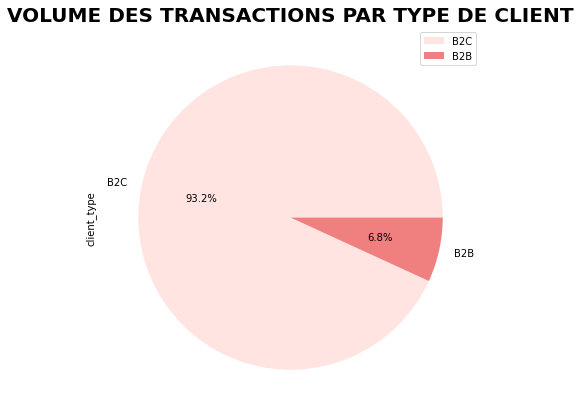

In [13]:
# Analyse de la répartition de la clientèle
plt.figure(figsize=(7,7))
df['client_type'].value_counts(normalize=True).plot(
    kind='pie', 
    legend=True,
    autopct='%1.1f%%', 
    colors= ["mistyrose","lightcoral"])
plt.title('VOLUME DES TRANSACTIONS PAR TYPE DE CLIENT', weight='bold',size=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.show()

Selon notre hypothèse, la clientèle profesionnelle représente **6,8%** de l'ensemble des transactions. Quant à elle, la clientèle de particuliers représente **93,2%** du volume des ventes

## 2. Analyse approfondie des tendances <a name="Subparagraph2"></a>
Ensuite, nous procédons à une analyse plus pousée des informations du dataframe pour rendre compte des tendances globales. Nous étudions le chiffre d'affaires, **sa répartion dans le temps, les produits par catégorie etc...**

price                    
categ              0         1         2
month_year                              
2022-01     0.297897  0.410361  0.291742
2022-02     0.313346  0.321553  0.365102
2022-03     0.345721  0.328992  0.325287
2022-04     0.326807  0.321855  0.351338
2022-05     0.351029  0.326740  0.322231
2022-06     0.346338  0.335555  0.318108
2022-07     0.335913  0.307101  0.356986
2022-08     0.325804  0.342650  0.331547
2022-09     0.344139  0.323738  0.332123
2022-10     0.341529  0.320812  0.337659
2022-11     0.346583  0.332042  0.321376
2022-12     0.326934  0.329149  0.343917

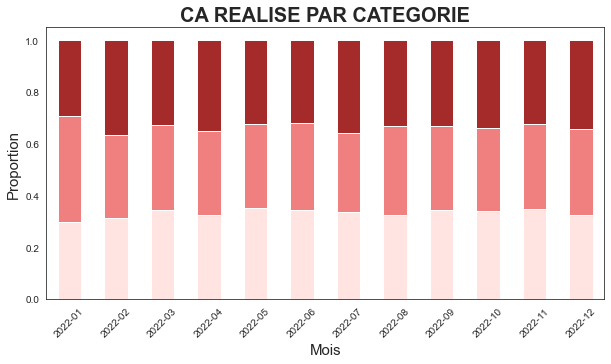

In [14]:
# Représentation graphique du chiffre d'affaires par catégorie (en %)

# Création du DF
ca_q = df.groupby(['month_year', 'categ']).price.sum()
df_ca_q = ca_q.to_frame()

# Style et paramétrage 
sns.set_style(style='white')
plt.rcParams["figure.figsize"] = [10, 5]

# Transformation en pourcentage
df_ca_q_per = df_ca_q.groupby(level='categ').apply(lambda x:100 * x / float(x.sum()))

# Pivotement de table
temp = df_ca_q_per.unstack(level='categ')
temp2 = temp.copy()
temp2.iloc[:,0] = temp.iloc[:,0] / (temp.iloc[:,0] + temp.iloc[:,1] + temp.iloc[:,2])
temp2.iloc[:,1] = temp.iloc[:,1] / (temp.iloc[:,0] + temp.iloc[:,1] + temp.iloc[:,2])
temp2.iloc[:,2] = temp.iloc[:,2] / (temp.iloc[:,0] + temp.iloc[:,1] + temp.iloc[:,2])
display(temp2)


# Génération du graphique
temp2.plot.bar(stacked=True, color=["mistyrose","lightcoral",'brown'], legend = False)

# Titre du graphique
plt.title('CA REALISE PAR CATEGORIE', weight='bold',size=20)

# Titre des axes
plt.xlabel("Mois", fontsize=15)
plt.ylabel("Proportion", fontsize=15)
plt.xticks(rotation=45)
plt.show()

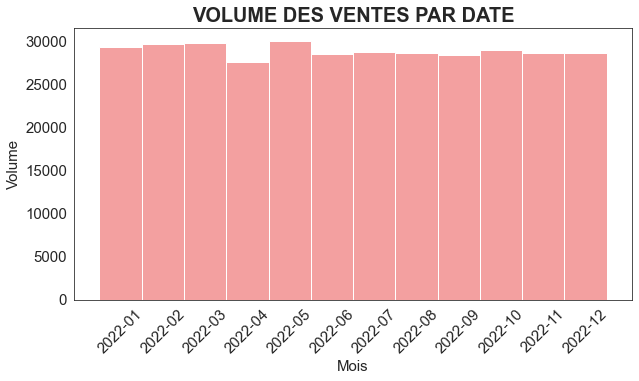

In [15]:
# Représentation graphique du volume de chiffre d'affaires sur l'année

# Style du graphique
plt.figure(figsize=(10,5))
sns.set_style(style='white')

# Génération du graphique
sns.histplot(data=df, x='month_year', multiple='stack',color="lightcoral", binwidth=7)

# Titre du axes
plt.title('VOLUME DES VENTES PAR DATE', weight='bold',size=20)

# Paramètre des axes
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

# Titre du axes
plt.xlabel("Mois", fontsize=15)
plt.ylabel("Volume", fontsize=15)
plt.xticks(rotation=45)

plt.show()

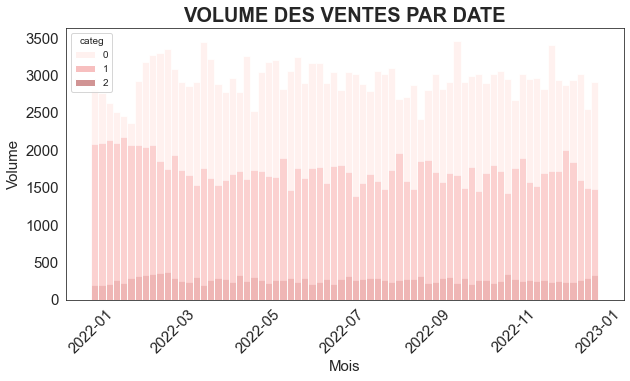

In [16]:
# Représentation graphique du volume de ventes sur l'année

# Style du graphique
plt.figure(figsize=(10,5))
sns.set_style(style='white')

# Génération du graphique
sns.histplot(data=df, x='Date', hue='categ', palette=["mistyrose","lightcoral",'brown'])

# Titre du graphique
plt.title('VOLUME DES VENTES PAR DATE', weight='bold',size=20)

# Paramètre des axes
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

# Titre des axes
plt.xlabel("Mois", fontsize=15)
plt.ylabel("Volume", fontsize=15)
plt.xticks(rotation=45)
plt.show()

,Week_Number,categ,price,7day_rolling_avg
0,00,0,6017.64,NaN
1,00,1,9073.70,NaN
2,00,2,2004.56,NaN
3,01,0,39805.18,NaN
4,01,1,56081.96,NaN
5,01,2,22154.33,NaN
6,02,0,37739.11,24696.640000
7,02,1,58419.37,32182.601429
8,02,2,22251.50,34065.144286
9,03,0,36383.38,38976.404286


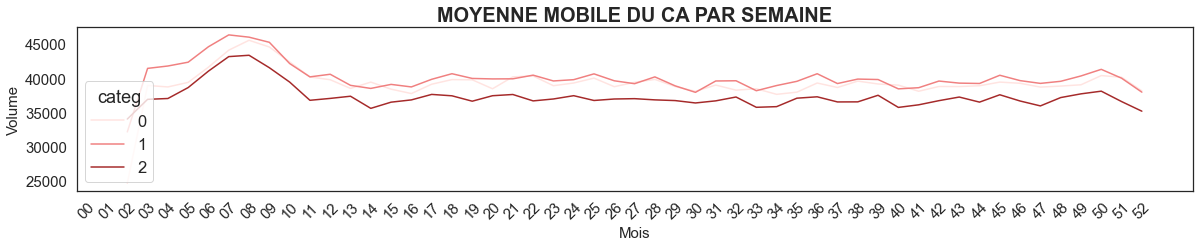

In [84]:
# Création d'une colonne semaine
df['Week_Number'] = df['Date'].dt.strftime('%U')

# Création d'une moyenne mobile du CA par semaine
table_ca = pd.pivot_table(df, values=['price'], index=['Week_Number','categ'], aggfunc=sum).reset_index()
table_ca[ '7day_rolling_avg' ] = table_ca.price.rolling(7).mean()
display(table_ca.head(10))

# Style du graphique
plt.figure(figsize=(20,3))
sns.set_style(style='white')

# Génération du graphique
sns.lineplot(data=table_ca, x='Week_Number', y='7day_rolling_avg', hue='categ', palette=["mistyrose","lightcoral",'brown'])

# Titre du graphique
plt.title('MOYENNE MOBILE DU CA PAR SEMAINE', weight='bold',size=20)

# Paramètre des axes
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xticks(rotation=45)

# Titre des axes
plt.xlabel("Mois", fontsize=15)
plt.ylabel("Volume", fontsize=15)
plt.show()

,Week_Number,categ,session_id,7day_rolling_avg
0,00,0,547,NaN
1,00,1,434,NaN
2,00,2,29,NaN
3,01,0,3784,NaN
4,01,1,2773,NaN


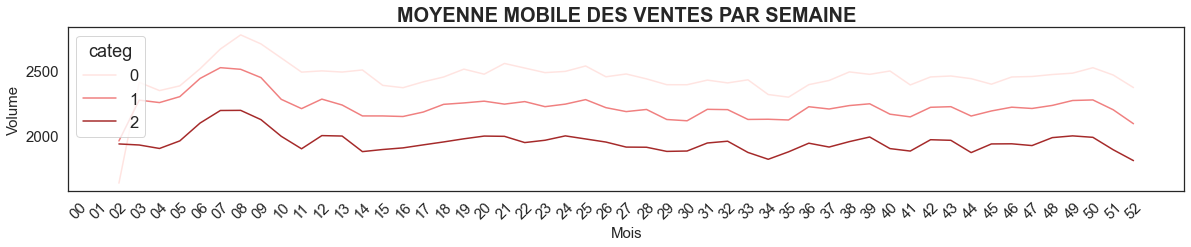

In [83]:
# Création d'une moyenne mobile du CA par semaine
table_sales = pd.pivot_table(df, values=['session_id'], index=['Week_Number','categ'], aggfunc='count').reset_index()
table_sales[ '7day_rolling_avg' ] = table_sales.session_id.rolling(7).mean()
display(table_sales.head())

# Style du graphique
plt.figure(figsize=(20,3))
sns.set_style(style='white')

# Génération du graphique
sns.lineplot(data=table_sales, x='Week_Number', y='7day_rolling_avg', hue='categ', palette=["mistyrose","lightcoral",'brown'])

# Titre du graphique
plt.title('MOYENNE MOBILE DES VENTES PAR SEMAINE', weight='bold',size=20)

# Paramètre des axes
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xticks(rotation=45)

# Titre des axes
plt.xlabel("Mois", fontsize=15)
plt.ylabel("Volume", fontsize=15)
plt.show()

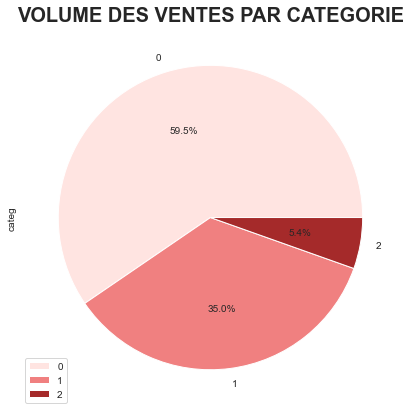

In [17]:
# Pourcentage des ventes par catégorie

# Style du graphique
plt.figure(figsize=(7,7))
sns.set_style(style='white')

# Génération du graphique
df['categ'].value_counts(normalize=True).plot(
    kind='pie',
    legend=True,
    autopct='%1.1f%%', 
    colors= ["mistyrose","lightcoral",'brown'])

# Titre du graphique
plt.title('VOLUME DES VENTES PAR CATEGORIE', weight='bold',size=20)

plt.show()

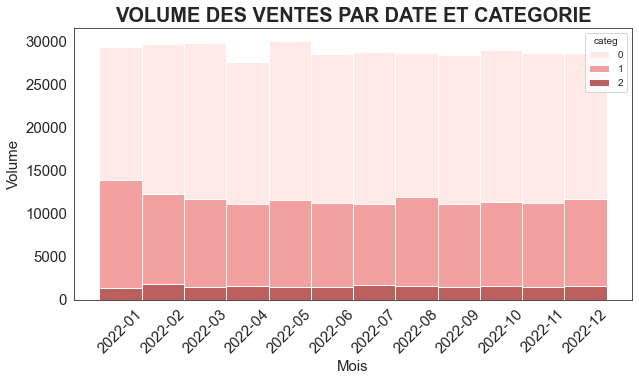

In [18]:
# Représentation graphique des volumes de transaction par catégorie

# Style du graphique
plt.figure(figsize=(10,5))
sns.set_style(style='white')

# Génération du graphique
sns.histplot(data=df, x='month_year', hue='categ', multiple='stack', binwidth=7, palette= ["mistyrose","lightcoral",'brown'])

# Titre du graphique
plt.title('VOLUME DES VENTES PAR DATE ET CATEGORIE', weight='bold',size=20)

# Paramètrage des axes
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xticks(rotation=45)

# Titre des axes
plt.xlabel("Mois", fontsize=15)
plt.ylabel("Volume", fontsize=15)

plt.show()

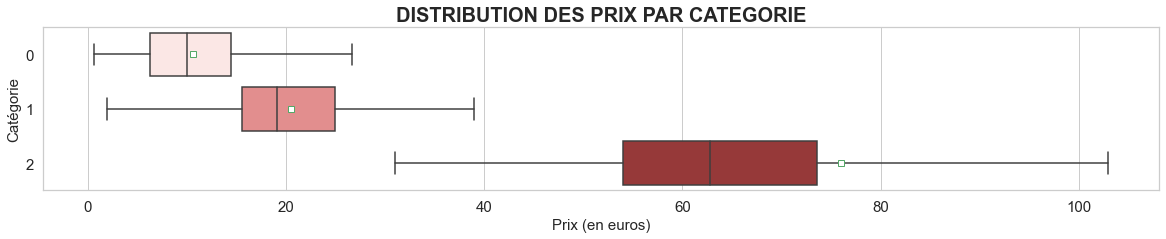

In [19]:
# Observation de la distribution des prix

# Style du graphique
plt.figure(figsize=(20,3))
sns.set(font_scale = 1.5) 
sns.set_style('whitegrid')

# Génération du graphique
sns.boxplot(data=df, y='categ', x='price', orient='h', showfliers=False,
            showmeans=True, palette=["mistyrose", "lightcoral", "brown"],
            meanprops={"marker":"s","markerfacecolor":"white"})

# Titre du graphique
plt.title("DISTRIBUTION DES PRIX PAR CATEGORIE",weight='bold', size=20)

# Paramètrage des axes
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

# Titre des axes
plt.xlabel('Prix (en euros)', fontsize=15)
plt.ylabel('Catégorie', fontsize=15)
plt.show()

Incide de Gini : 0.7438093125119756


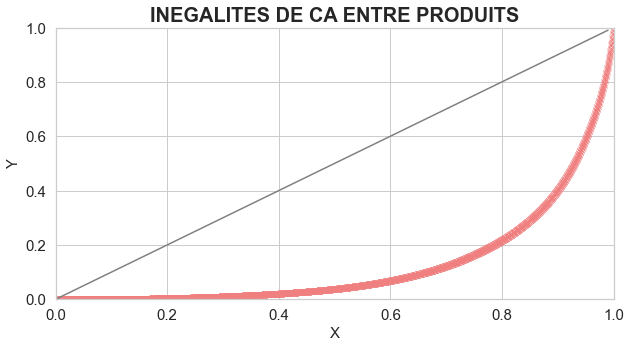

In [20]:
# Analyse de la concentration des richesses

# Fonction pour la courbe de lorenz
def lorenz(variable, title):
    X = variable.values
    X = np.sort(X)
    
    # Fonction pour l'indice de Gini
    def gini(array):
        array
        sorted_array = array.copy()
        sorted_array.sort()
        n = array.size
        coef_ = 2. / n
        const_ = (n + 1.) / n
        weighted_sum = sum([(i+1)*yi for i, yi in enumerate(sorted_array)])
        return coef_*weighted_sum/(sorted_array.sum()) - const_
    print('Incide de Gini :', gini(X))
    
    # Courbe de Lorenz
    X_lorenz = X.cumsum() / X.sum()
    X_lorenz = np.insert(X_lorenz, 0, 0)
    # X_lorenz[0], X_lorenz[-1]
    y = np.arange(X_lorenz.size)/(X_lorenz.size-1)
    lorenz = pd.DataFrame()
    lorenz['X'] = pd.Series(X_lorenz)
    lorenz['Y'] = pd.Series(y)
    sns.scatterplot(data=lorenz, x='Y', y='X', marker='x', color="lightcoral")

    # Diagonale
    a = np.arange(0,1,.01)
    x = a
    y = a
    
    # Génération du graphique
    sns.lineplot(x=x,y=y, color="grey")
    
    # Titre du graphique
    plt.title(title, weight='bold', size=20)
    
    # Paramètre des axes
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    # Titre des axes
    plt.xlabel('X', fontsize=15)
    plt.ylabel('Y', fontsize=15)
    plt.show()
    
# Inégalités des chiffres d'affaires annuels par produit
plt.figure(figsize=(10,5))
sns.set_style('whitegrid')
lorenz(df.pivot_table(index='id_prod', aggfunc='sum')['price'], 'INEGALITES DE CA ENTRE PRODUITS')

Incide de Gini : 0.4587807029895652


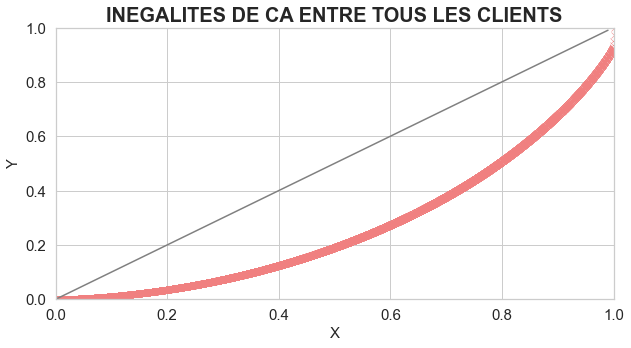

In [21]:
# Inégalité des chiffres d'affaires annuels de tous les clients
plt.figure(figsize=(10,5))
sns.set_style('whitegrid')
lorenz(ca_annuel['total_purchase'], 'INEGALITES DE CA ENTRE TOUS LES CLIENTS')

Incide de Gini : 0.41614053706413334


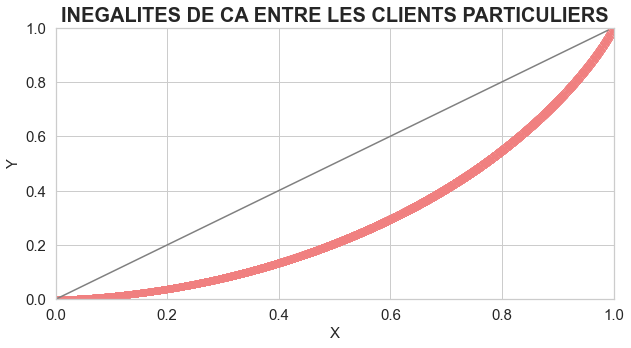

In [22]:
# Inégalité des chiffres d'affaires annuels des clients particuliers
plt.figure(figsize=(10,5))
lorenz(b2c.pivot_table(index='client_id')['total_purchase'], 'INEGALITES DE CA ENTRE LES CLIENTS PARTICULIERS')

# 3. Profil de consommation des clients <a name="paragraph2"></a>

Nous mentionnions dans l'étape précédente (le nettoyage des données) la nécessité de supprimer quelques lignes pour mener notre analyse. Pour analyser le comportement des clients, Nous allons supprimer les lignes ou des valeurs sont manquantes pour les variables sex, birth, age.

In [23]:
# Supression des identifiants clients dont nous n'avons pas besoin
b2c=b2c[b2c["client_id"]!="c_577"]
b2c=b2c[b2c["client_id"]!="c_5302"]
b2c=b2c[b2c["client_id"]!="c_8362"]

# Vérification de la supression sur un des identifiants
print(np.where(b2c['id_prod'] == "c_577"))

(array([], dtype=int64),)


In [24]:
# Hiérarchisation des classes d'âge
b2c['AGE_PERIOD'] = pd.Categorical(b2c['AGE_PERIOD'],
                                   ["15 - 19",
                                    "20 - 24",
                                    "25 - 29",
                                    "30 - 34",
                                    "35 - 39",
                                    "40 - 44",
                                    "45 - 49",
                                    "50 - 54",
                                    "55 - 59",
                                    "60 - 64",
                                    "65 - 69",
                                    "70 - 74",
                                    "75 - 79",
                                    "80 - 84",
                                    "85 - 89",
                                    "90 - 95"])

## A.Les clients particuliers <a name="Subparagraph3"></a>

In [25]:
# âge moyen
print("L'âge moyen est de :", round(b2c['age'].mean()),"ans")

print("L'âge moyen des hommes est de :", round(b2c['age'][ b2c['sex'] == "m" ].mean()),"ans")

print("L'âge moyen des femmes est de :", round(b2c['age'][ b2c['sex'] == "f" ].mean()),"ans")

L'âge moyen est de : 44 ans
L'âge moyen des hommes est de : 44 ans
L'âge moyen des femmes est de : 45 ans


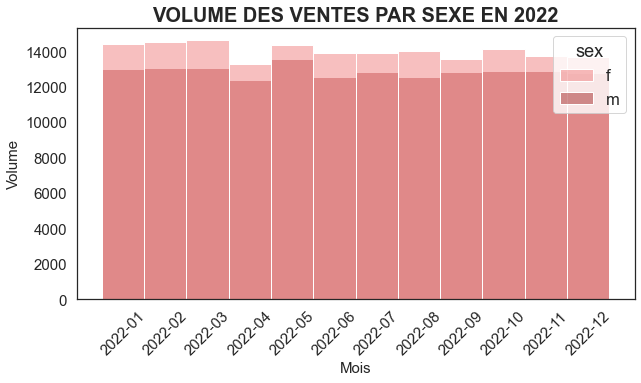

In [26]:
# Représentation graphique des volumes de ventes par sexe

# Style du graphique
plt.figure(figsize=(10,5))
sns.set_style(style='white')

# Génération du graphique
sns.histplot(data=b2c, x='month_year', hue='sex', binwidth=7, palette= ["lightcoral","brown"])

# Titre du graphique
plt.title("VOLUME DES VENTES PAR SEXE EN 2022", weight='bold', size=20)

# Paramètre des axes
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xticks(rotation=45)

# Titre des axes
plt.xlabel('Mois', fontsize=15)
plt.ylabel('Volume', fontsize=15)

plt.show()

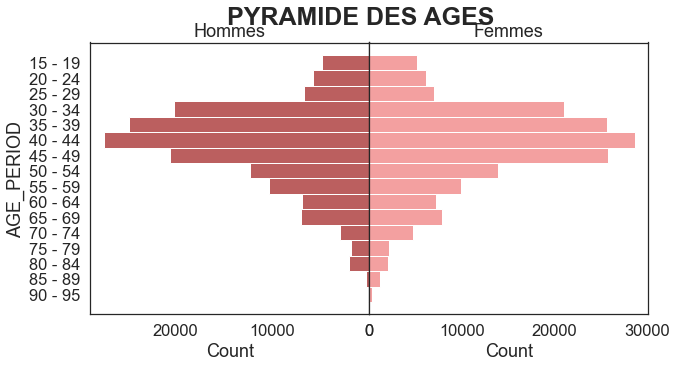

In [65]:
# Création d'une pyramide des ages


fig, axes = plt.subplots(1, 2)

# Titre du graphique
fig.suptitle('PYRAMIDE DES AGES', weight='bold', size=25)

# Génération du graphique "hommes"
sns.histplot(ax=axes[0], y=b2c[b2c['sex']=='m']['AGE_PERIOD'], bins=12, color ='brown')

# Paramètre des axes
axes[0].invert_xaxis()
axes[0].set_title('Hommes')

# Génération du graphique "femmes"
sns.histplot(ax=axes[1], y=b2c[b2c['sex']=='f']['AGE_PERIOD'], bins=12, color= 'lightcoral')

# Paramètre des axes
axes[1].set_yticklabels([])
axes[1].set_ylabel('')
axes[1].set_title('Femmes')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

Face à la similarité des données lors de l'analyse sur le genre, nous souhaitons directement regarder s'il y a une corrélation entre le sexe et toutes les autres variables. Nous allons donc procéder à matrice de corrélation.

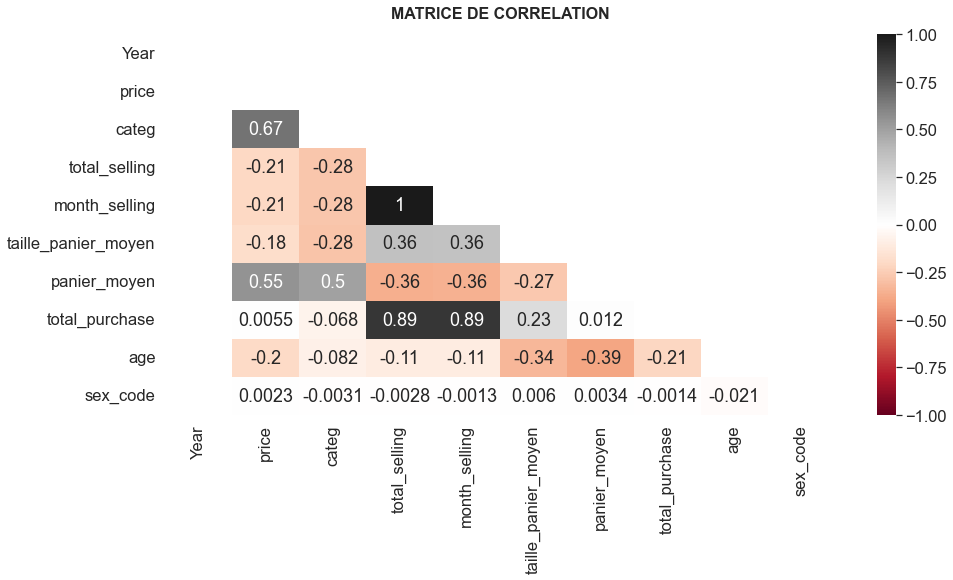

In [28]:
# Formater la variable sex pour l'utiliser
b2c = pd.concat([b2c,
    pd.get_dummies(b2c['sex'], drop_first=True).rename(columns={'m': 'sex_code'})],
    axis=1)

# représenter les liens entre la variable sexe et les autres
plt.figure(figsize=(15, 7))

# Génération du graphique
heatmap = sns.heatmap(
    b2c.corr(), 
    mask=np.triu(np.ones_like(b2c.corr(), dtype=np.bool_)), 
    vmin=-1, vmax=1, annot=True, cmap='RdGy')

# Titre du graphique
heatmap.set_title('MATRICE DE CORRELATION',weight='bold', fontdict={'fontsize':16}, pad=16)
plt.show()

Les taux de corrélation de la variable sexe sont proches de 0. De ce fait, nous notons une absence de corrélation pour cette variable. On va aller plus loin pour définir véritablement s'il existe des liens avec une analyse du chi-deux.


In [29]:
# Table de contingence
crosstab = pd.crosstab(b2c['categ'], b2c['sex'], margins=False)
print('Table de contingence :')
print(crosstab)

# Table de contingence proratisée
table, results = rp.crosstab(b2c['categ'], b2c['sex'], prop='col', test='chi-square')
print('\n' + '-' * 55, '\n\nTable de contingence proratisée :')
print(table)

Table de contingence :
sex        f      m
categ              
0      99961  92431
1      59574  53759
2       8755   8190

------------------------------------------------------- 

Table de contingence proratisée :
         sex                
sex        f       m     All
categ                       
0       59.4   59.87   59.63
1       35.4   34.82   35.12
2        5.2    5.31    5.25
All    100.0  100.00  100.00


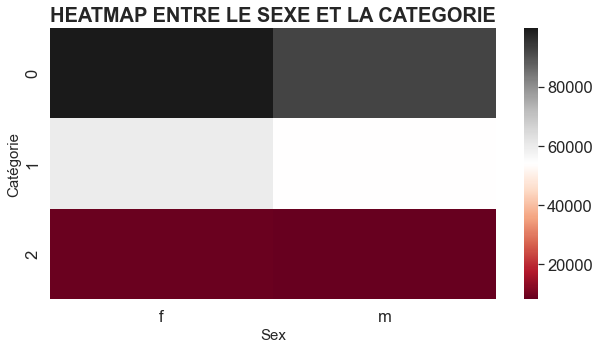

In [30]:
# Heatmap de compraison entre le sexe et la catégorie

# Génération du graphique
sns.heatmap(crosstab, cmap="RdGy")

# Titre du graphique
plt.title('HEATMAP ENTRE LE SEXE ET LA CATEGORIE', weight='bold', size=20)

# Titre des axes
plt.xlabel('Sex', fontsize=15)
plt.ylabel('Catégorie', fontsize=15)
plt.show()

In [31]:
# Test de Chi 2

sample_b2c = b2c.sample(1500)
table = pd.crosstab(sample_b2c['categ'], sample_b2c['sex'], margins=False)
stat, p, dof, expected = stats.chi2_contingency(table)
print('Test de Chi 2 (2 catégorielles)')
print('Stat = %.3f\np-value = %.35f' % (stat, p))
if p > .05:
    print('H0: les échantillons sont indépendants')
else:
    print('H1: Il y a une relation de dépendance entre les échantillons.')
print('\nConditions :\n'
      '- Les observations utilisées dans le calcul de la table de contingence sont indépendantes.',
      '\n- 25 exemples ou plus dans chaque cellule du tableau de contingence.')

Test de Chi 2 (2 catégorielles)
Stat = 3.049
p-value = 0.21777839318215114206012117392674554
H0: les échantillons sont indépendants

Conditions :
- Les observations utilisées dans le calcul de la table de contingence sont indépendantes. 
- 25 exemples ou plus dans chaque cellule du tableau de contingence.


Le test d'indépendance du χ² mesure la corrélation entre 2 variables qualitatives.
Maintenant, nous allons étudier la distribution des âges de la clientèle et déterminer les liens avec d'autres variables.

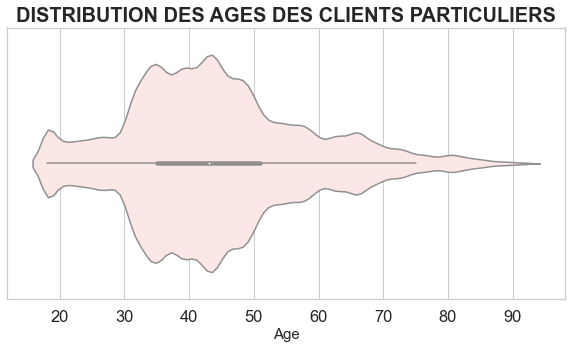

In [32]:
# Distribution des âges

# Style du graphique
plt.figure(figsize=(10,5))
sns.set_style('whitegrid')

# Génération du graphique
sns.violinplot(data=b2c, x='age', showfliers=False, color="mistyrose")

# Titre du graphique
plt.title('DISTRIBUTION DES AGES DES CLIENTS PARTICULIERS', weight='bold', size=20)

# Titre des axes
plt.xlabel('Age', fontsize=15)
plt.show()

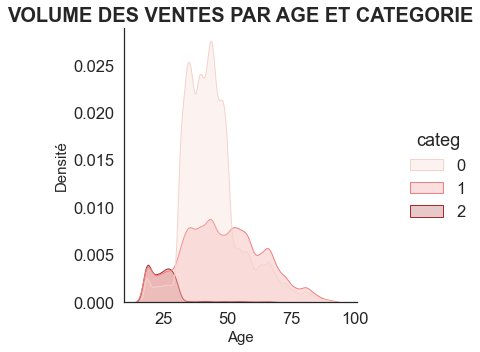

In [33]:
# Représentation des volumes de transaction par age et par catégorie

# Style du graphique
plt.rcParams["figure.figsize"] = [10, 5]
sns.set_style('white')

# Génération du graphique
sns.displot(data=b2c, x='age', hue='categ', kind='kde', palette=["#f4d3cb", "lightcoral", "brown"], fill=True)

# Titre du graphique
plt.title('VOLUME DES VENTES PAR AGE ET CATEGORIE', weight='bold', size=20)

# Titre des axes
plt.xlabel('Age', fontsize=15)
plt.ylabel('Densité', fontsize=15)
plt.show()

On note de grandes différences dans les ventes entre l'âge et les catégories.

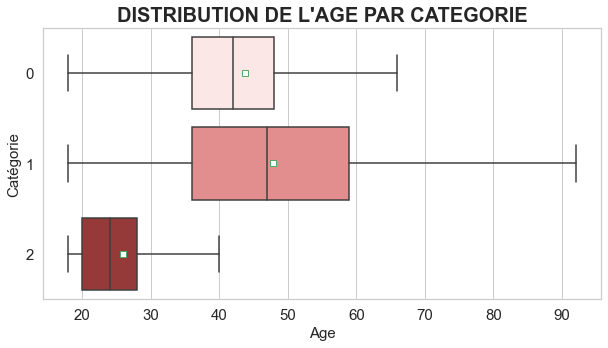

In [34]:
# Observation de la distribution de l'âge par catégorie

# Style du graphique
plt.figure(figsize=(10,5))
sns.set(font_scale = 1.5) 
sns.set_style('whitegrid')

# Génération du graphique
sns.boxplot(data=b2c, y='categ', x='age', orient='h', showfliers=False,
            showmeans=True, palette=["mistyrose", "lightcoral", "brown"],
            meanprops={"marker":"s","markerfacecolor":"white"})

# Titre du graphique
plt.title("DISTRIBUTION DE L'AGE PAR CATEGORIE",weight='bold', size=20)

# Paramètre des axes
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

# Titre des axes
plt.xlabel('Age', fontsize=15)
plt.ylabel('Catégorie', fontsize=15)
plt.show()

Cette différence dont nous parlions précédemment est également perceptible lorsque l'on s'intéresse à la distribution de l'âge par catégorie. On va rentrer dans les détails des classes d'âge pour affiner l'analayse.

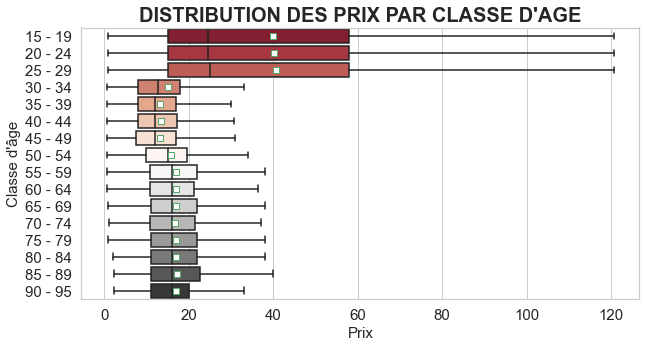

In [35]:
# Observation de la distribution des prix par classe d'âge
plt.figure(figsize=(10, 5))

# Génération du graphique
sns.boxplot(data=b2c.sort_values(by='AGE_PERIOD'), y='AGE_PERIOD', x='price', showfliers=False, palette ='RdGy', showmeans=True, meanprops={"marker":"s","markerfacecolor":"white"})

# Titre du graphique
plt.title("DISTRIBUTION DES PRIX PAR CLASSE D'AGE", weight='bold', size=20)

# Paramètre des axes
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

# Titre des axes
plt.xlabel('Prix', fontsize=15)
plt.ylabel("Classe d'âge", fontsize=15)
plt.show()

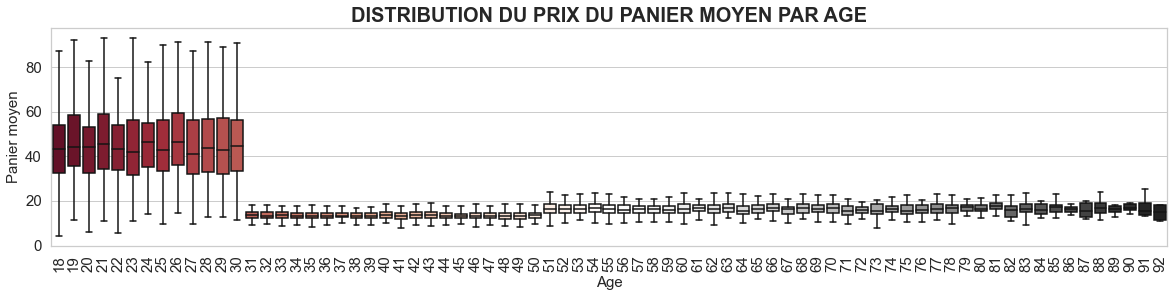

In [36]:
# Représentation de la distribution du prix du panier moyen

# Style du graphique
plt.figure(figsize=(20,4))
sns.set_style('whitegrid')

# Génération du graphique
sns.boxplot(
    data=b2c.pivot_table(index=['client_id']),
    y='panier_moyen', x='age', palette= 'RdGy', showfliers=False)

# Titre du graphique
plt.title('DISTRIBUTION DU PRIX DU PANIER MOYEN PAR AGE', weight='bold', size=20)

# Paramètre des axes
plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

# Titre des axes
plt.xlabel("Age", fontsize=15)
plt.ylabel("Panier moyen", fontsize=15)
plt.show()

Le prix du panier moyen reflete bien la tendance observée dans la distribution des prix par classe d'âge.

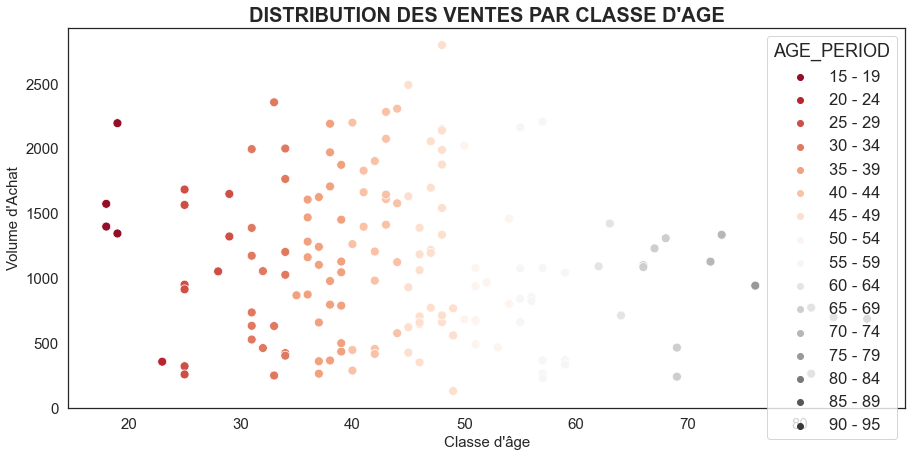

In [37]:
# représentation du volume des ventes par classe d'âge

# Style du graphique
plt.figure(figsize=(15, 7))
sns.set_style('white')

# Génération du graphique
sns.scatterplot(data=b2c.sample(150), x='age', y='total_purchase', hue='AGE_PERIOD', palette="RdGy", s=80 )

# Titre du graphique
plt.title("DISTRIBUTION DES VENTES PAR CLASSE D'AGE", weight='bold', size=20)

# Paramètre des axes
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

# Titre des axes
plt.xlabel("Classe d'âge", fontsize=15)
plt.ylabel("Volume d'Achat", fontsize=15)
plt.show()

Les représentations ci-dessus nous informent de trois tendances importantes : Les clients de moins de 30 ans sont ceux qui vont acheter les livres les plus chers, ils consomment davantage la catégorie 2. Le prix du panier moyen justifie cet élément pour cette classe d'âge. 
A l'inverse, les clients agés entre 30 et 50 ans consommeront des livres de la catégorie 0 au prix moins élevé. 
Enfin, les clients agés de plus de 30 ans ont des tendances d'achat moins ciblées, plus variées.

<Figure size 1080x504 with 0 Axes>

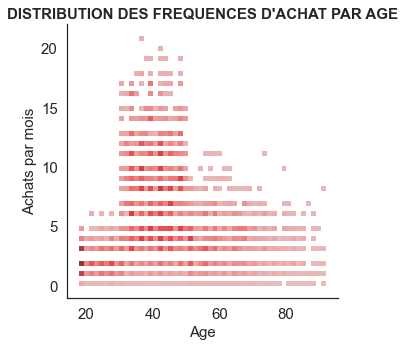

In [38]:
# représentation de la distribution des fréquences d'achat

# Style du graphique
plt.figure(figsize=(15,7))
sns.set_style('white')

# Génération du graphique
sns.displot(x='age', y='month_selling', data=b2c, color="brown", bins=50)

# Titre du graphique
plt.title("DISTRIBUTION DES FREQUENCES D'ACHAT PAR AGE", weight='bold', size=15)

# Paramètre des axes
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

# Titre des axes
plt.xlabel("Age", fontsize=15)
plt.ylabel("Achats par mois", fontsize=15)
plt.show()

Le nombre de livres achetés par mois renforce les tendances préalablement observées sur les 3 groupes d'âge. Les moins de 30 ans achètent peu de livres. A l'inverse, les clients âgés de 30 à 50 ans se démarquent fortement par leur volume d'achat. Enfin, les plus de 50 ans ont des habitudes plus variées, mais achètent rarement plus de 5 livres.

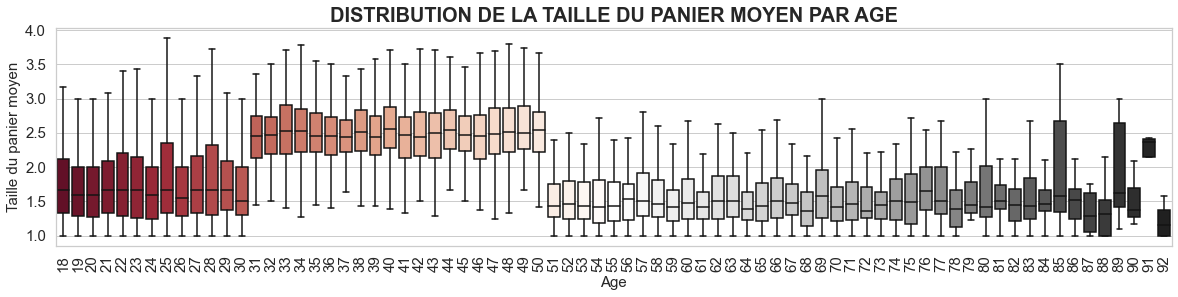

In [39]:
# Représentation de la distribution de la taille du panier moyen
plt.figure(figsize=(20,4))
sns.set_style('whitegrid')

# Génération du graphique
sns.boxplot(
    data=b2c.pivot_table(index=['client_id']),
    y='taille_panier_moyen', x='age', showfliers=False, palette='RdGy')

# Titre du graphique
plt.title('DISTRIBUTION DE LA TAILLE DU PANIER MOYEN PAR AGE', weight='bold', size=20)

# Paramètre des axes
plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

# Titre des axes
plt.xlabel("Age", fontsize=15)
plt.ylabel("Taille du panier moyen", fontsize=15)
plt.show()

La taille du panier moyen est également révélatrice des tendances observés ci-dessus. 

Nous allons à présent établir des tests statistiques pour répondre à la demande initiale et connaître l'existence d'une corrélation entre l'âge des clients et les catégories de produits achetés, car nous avons vu qu'il existait une relation entre ces variables.

In [40]:
# Test d'ANOVA
sample_df = b2c.sample(5000)
model = smf.ols('age ~ categ', data=sample_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
p = anova_table['PR(>F)'][0]
print('ANOVA\np-value :', p, '\nstat (F) :', anova_table['F'][0])
if p > 0.05:
    print('H0: les moyennes des échantillons sont égales.')
else:
    print("H1: une ou plusieurs des moyennes de l'échantillon sont inégales."
         '\n\nConditions :'
         '\n1. Normalité des résidus\n2. Homoscédasticité')

ANOVA
p-value : 1.391232758322501e-12 
stat (F) : 50.45409083232436
H1: une ou plusieurs des moyennes de l'échantillon sont inégales.

Conditions :
1. Normalité des résidus
2. Homoscédasticité


On observe des différences entre les variances des âges pour chaque catégorie. On va essayer d'aller plus loin en prouvant statistiquement cette différence.

Normalité des résidus (Shapiro)

stats : 0.965131938457489 
p-value : 3.9233303126464514e-33
H0 rejetée : distribution anormale


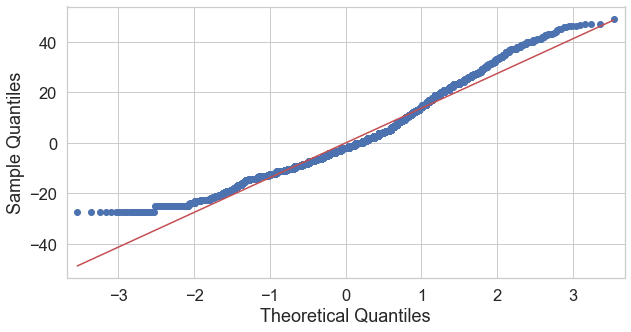

In [41]:
# Test de Shapiro sur les résidus
print('Normalité des résidus (Shapiro)')
print('\nstats :', stats.shapiro(model.resid)[0],
    '\np-value :', stats.shapiro(model.resid)[1])
if p>.05:
    print('H0 acceptée : distribution normale')
else:
    print('H0 rejetée : distribution anormale')
qqplot(model.resid, line='s')
plt.show()

Normalité des résidus après boxcox :
stats : nan 
p-value : 1.0
H0 acceptée : distribution normale


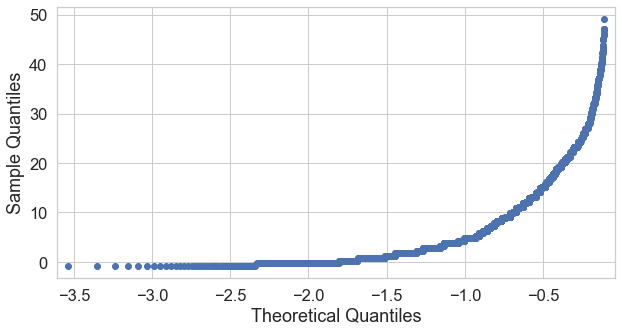

In [42]:
from scipy.special import boxcox1p

# Test de Shapiro sur les résidus après boxcox
residus = boxcox1p(model.resid, 1)
p = stats.shapiro(residus)[1]
print('Normalité des résidus après boxcox :'
    '\nstats :', stats.shapiro(residus)[0],
    '\np-value :', p)
if p>.05:
    print('H0 acceptée : distribution normale')
else:
    print('H0 rejetée : distribution probablement pas normale')
qqplot(residus, line='s')
plt.show()

Enfin, nous allons tester l'homoscédasticité des résidus, pour s'assurer que les variances sont égales. Le test de Levene n'est pas concluant. Dans le cas où la condition d'homoscédasticité n'est pas remplie, on peut utiliser Welch ANOVA : ce test valide ici la corrélation entre prix et catégorie.

In [43]:
# Test de Levene sur les 3 catégories
samples = 4000
a = df[df['categ']==0]['age'].sample(samples).values
b = df[df['categ']==1]['age'].sample(samples).values
c = df[df['categ']==2]['age'].sample(samples).values
stat, p = stats.levene(a, b, c)
print('Condition 2 : homoscédasticité (Levene)',
    '\nstats :', stat,
    '\np-value :', p)
if p > 0.05:
    print('H0: les variances sont égales')
else:
    print('H1: les variances ne sont pas égales (essayer Welch ANOVA)')
print('\nConditions :'
      '\n- The samples from the populations under consideration are independent',
      '\n- The populations under consideration are approximately normally distributed')  

Condition 2 : homoscédasticité (Levene) 
stats : 672.4690654761848 
p-value : 1.554669263964012e-277
H1: les variances ne sont pas égales (essayer Welch ANOVA)

Conditions :
- The samples from the populations under consideration are independent 
- The populations under consideration are approximately normally distributed


In [44]:
# Test de Welch entre catégorielle et quantitative
stat, p = stats.ttest_ind(sample_df['age'], sample_df['categ'])
print('Test de Welch (si absence d\'homoscédasticité)\n')
print('p-value :', p, '\nstat :', stat)
if p > 0.05:
    print('H0: les moyennes des échantillons sont égales')
else:
    print('H1: une ou plus des moyennes des échantillons sont inégales')

Test de Welch (si absence d'homoscédasticité)

p-value : 0.0 
stat : 222.7435332116576
H1: une ou plus des moyennes des échantillons sont inégales


### Observations :

Nous pouvons tirer plusieurs choses de l'analyse de la cientèle des particuliers :

- On observe que la périodicité des ventes est très similaire entre les deux sexes. Les effectifs de ventes pour chaque sexe sont équilibrés. Les catégories y apparaissent dans les mêmes proportions. Le test de correlation renseigne sur l'absence de corrélation pour cette variable.
- Lorsqu'on s'intéresse à l'âge on découvre que plus de la moitié des achats concerne les clients agés entre 30 et 50 ans. Les 3 catégories sont consommées par l'ensemble des classes d'âge à des niveaux variables. La catégorie 0 est principalement achetée par les clients agés entre 30 et 50 ans. la catégorie 2 est consommée presque exclusivement par les moins de 30 ans. Quant à la catégorie 1, sa distribution est bien plus large et touche l'ensemble de l'échantillon.
- Le chiffre d'affaires annuel des clients particuliers semble lié à la classe d'âge. Nous avons vu que la catégorie 0 est de loin la catégorie la plus consommée par les 30-50 ans. la catégorie 2 est presque exclusivement achetée par les moins de 30 ans, en plus de concentrer les livres les plus chers. 
- En termes de concentration de chiffres d'affaires les clients agés de 30 à 50 ans détiennent la plus grande part grâce aux volumes achetés. En second position, ce sont les moins de 30 ans grâce au prix du panier moyen qui compense les quantités achetées. En dernière position, on retrouve les plus de 50 ans avec des comportements bien plus versatiles.
- Il y a bien une corrélation entre le prix et la catégorie. Celle-ci est renseignée par les différents tests statistiques effectués.



## B.Les clients professionnels <a name="Subparagraph4"></a>

Contrairement à l'analyse réalisée sur la clientèle des particuliers, ici, il ne servirait à rien de produire des chiffres clés sur le sex ou l'âge pour la clientèle b2b, cela ne serait pas représentatif. Nous allons plutôt nous intéresser aux achats et au chiffre d'affaires de ces quelques clients au travers d'une analyse concise.

<Figure size 504x504 with 0 Axes>

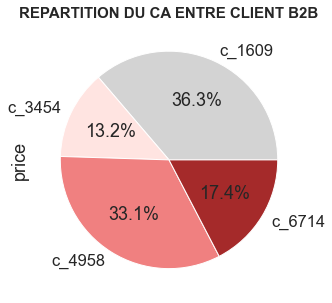

In [45]:
# Représentation du chiffre d'affaires des clients professionnels

# Style du graphique
plt.figure(figsize=(7,7))
sns.set_style(style='white')

# Génération du graphique
data=b2b.pivot_table(index='client_id', aggfunc={'price': np.sum}).plot(
    kind='pie', y='price',
    legend=False,
    autopct='%1.1f%%',
    colors= ["lightgrey", "mistyrose","lightcoral",'brown'])

# Titre du graphique
plt.title('REPARTITION DU CA ENTRE CLIENT B2B', weight='bold',size=15)
plt.show()

Deux clients se démarquent en constribuant à près de 70%  du Chiffre d'affaires

<Figure size 504x504 with 0 Axes>

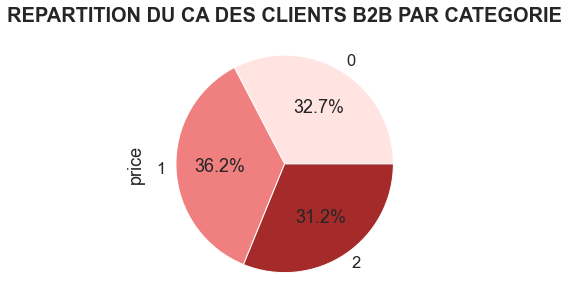

In [46]:
# Représentation du chiffre d'affaires des clients profesionnels par catégorie

# Style du graphique
plt.figure(figsize=(7,7))

# Génération du graphique
data=b2b.pivot_table(index='categ', aggfunc={'price': np.sum}).plot(
    kind='pie', y='price',
    legend=False,
    autopct='%1.1f%%',
    colors= ["mistyrose","lightcoral",'brown'])

# Titre du graphique
plt.title("REPARTITION DU CA DES CLIENTS B2B PAR CATEGORIE", weight='bold',size=20)
plt.show()

Cependant, la répartition du chiffre d'affaires est très similaire entre les 3 catégories.

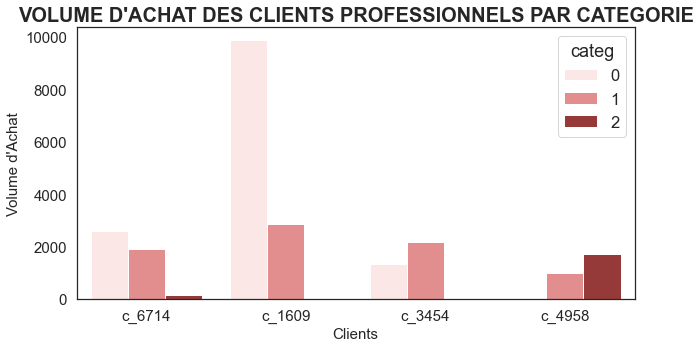

In [69]:
# Représentation du volume d'achats des clients professionnels

# Style du graphique
plt.figure(figsize=(10,5))
sns.set_style('white')

# Génération du graphique
sns.countplot(data=b2b, x='client_id', hue='categ', palette= ["mistyrose","lightcoral",'brown'])

# Titre du graphique
plt.title("VOLUME D'ACHAT DES CLIENTS PROFESSIONNELS PAR CATEGORIE", weight='bold', size=20)

# Paramètre des axes
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

# Titre des axes
plt.xlabel("Clients", fontsize=15)
plt.ylabel("Volume d'Achat", fontsize=15)
plt.show()

Visiblement, la représentation graphique des volumes d'achat semble indiquer des comportements différents chez ces clients.

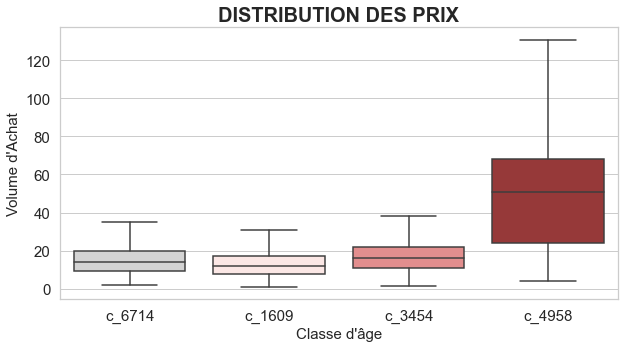

In [68]:
# Représentation de la distribution des prix d'achat

# Style du graphique
plt.figure(figsize=(10,5))
sns.set_style('whitegrid')

# Génération du graphique
sns.boxplot(data=b2b, y='price', x='client_id',palette= ["lightgrey", "mistyrose","lightcoral",'brown'], showfliers=False)

# Titre du graphique
plt.title("DISTRIBUTION DES PRIX", weight='bold', size=20)

# Paramètre des axes
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

# Titre des axes
plt.xlabel("Classe d'âge", fontsize=15)
plt.ylabel("Volume d'Achat", fontsize=15)
plt.show()

La distribution des prix est très similiaire entre les 3 premiers clients, seul le quatrième se démarque fortement. Cette représentation est cohérente car ce dernier achète principalement la catégorie 2.

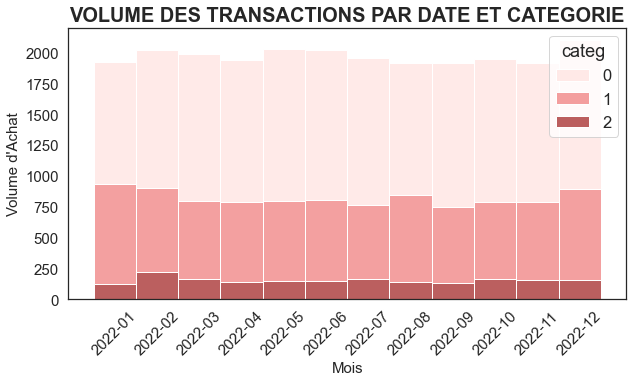

In [66]:
# Style du graphique
plt.figure(figsize=(10,5))
sns.set_style('white')

# Génération du graphique
sns.histplot(data=b2b, x='month_year', hue='categ', multiple='stack',palette= ["mistyrose","lightcoral",'brown'],  binwidth=7)

#Titre du graphique
plt.title("VOLUME DES TRANSACTIONS PAR DATE ET CATEGORIE", weight='bold', size=20)

# Paramètre des axes
plt.xticks(rotation=45)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

# Titre des axes
plt.xlabel("Mois", fontsize=15)
plt.ylabel("Volume d'Achat", fontsize=15)
plt.show()

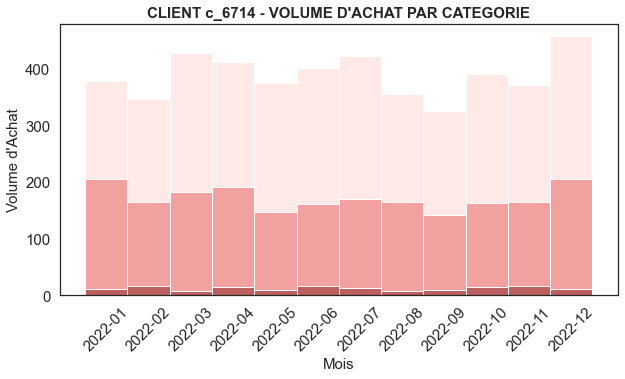

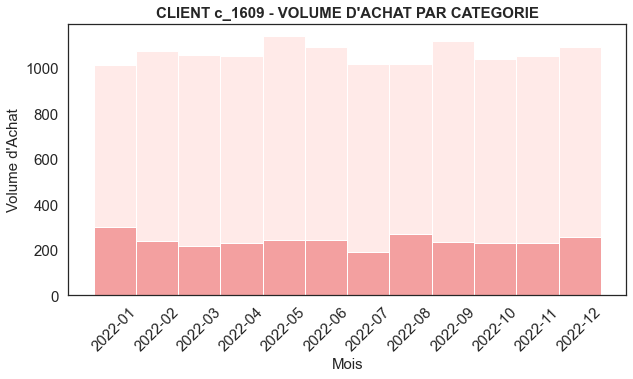

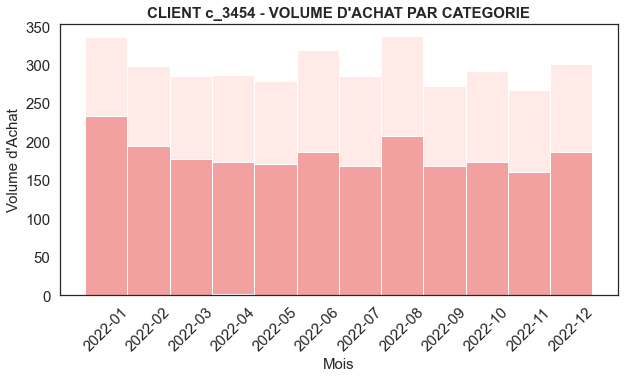

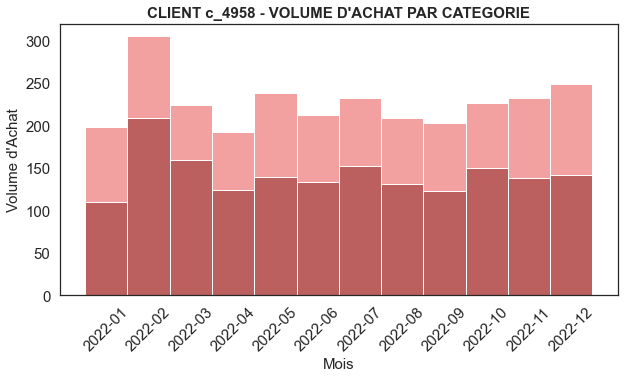

In [67]:
# Représentation des volumes d'achats par client
for i in b2b['client_id'].unique():
   
    temp_data = b2b[b2b['client_id']==i]
    temp_categ = temp_data['categ'].unique()
    temp_palette = []
    if 0 in temp_categ: temp_palette.append("mistyrose")
    if 1 in temp_categ: temp_palette.append("lightcoral")
    if 2 in temp_categ: temp_palette.append("brown")
   
    # Style du graphique
    plt.figure(figsize = (10,5))
    sns.set_style('white')
    
    # Génération du graphique
    sns.histplot(data = temp_data,
                 x = 'month_year',
                 hue = 'categ',
                 palette = temp_palette,
                 multiple='stack',
                 binwidth = 7,
                 legend = False)
    
    #Titre du graphique
    plt.title('CLIENT ' + i + " - VOLUME D'ACHAT PAR CATEGORIE", weight='bold', size=15)
    
    # Paramètre des axes
    plt.xticks(rotation = 45)
    plt.tick_params(axis = 'x', labelsize = 15)
    plt.tick_params(axis = 'y', labelsize = 15)
   
    # Titre des axes
    plt.xlabel("Mois", fontsize=15)
    plt.ylabel("Volume d'Achat", fontsize = 15)
    plt.show()
   
del temp_data, temp_categ, temp_palette

La périodicité d'achat semble différente selon les clients et les catégories consommées.

### Observations :

- Chaque client professionnel illustre un comportement d'achat unique. Plus spécifiquement, deux d'entre eux se démarquent fortement : le client c_1609 et le client c_4958. Le premier consomme, loin devant les autres, les catégories 0 et 1. Il contribue à la plus grande part de chiffre d'affaires b2b. Le second est l'un des seuls à consommer autant la catégorie 2. Même s'il consomme moins, le prix des produits le place en second position en termes de chiffre d'affaires réalisé.
- Bien qu'il existe des comportements différents, le chiffre d'affaires réalisé est sensiblement le même par catégorie de produit.
- La périodicité des achats présente des points communs en fonction des catégories là encore : la catégorie 0 est surtout achetée en Juin et Septembre, la catégorie 1 en Décembre, Janvier, Février et la catégorie 2 au mois de février et Mars.